In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BSSSBSBS'   #'BBBSBBBB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='BSSSBSBS'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     14.9| 30.4132| -86.6635|       PRCP|US1FLOK0014|    38|[00 00 00 00 B0 5...|2009.0|BSSSBSBS|
|     36.9| 30.5682| -88.2331|       PRCP|US1ALMB0011|    46|[00 7E 00 7E 00 7...|2008.0|BSSSBSBS|
|     36.9| 30.5682| -88.2331|       PRCP|US1ALMB0011|    33|[00 00 00 00 00 0...|2009.0|BSSSBSBS|
|     36.9| 30.5682| -88.2331|       PRCP|US1ALMB0011|    26|[00 00 00 00 00 0...|2010.0|BSSSBSBS|
|     36.9| 30.5682| -88.2331|       PRCP|US1ALMB0011|    15|[80 50 38 58 00 0...|2011.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [8]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2784, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

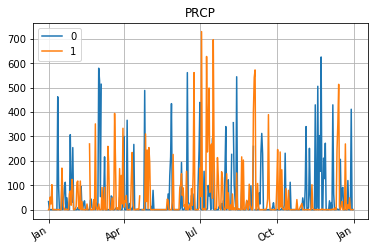

In [9]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[20:22].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

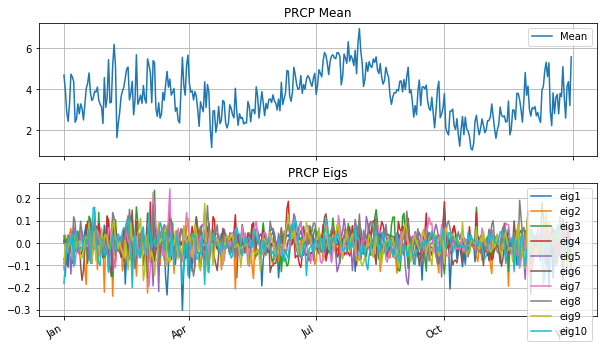

In [10]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=10
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

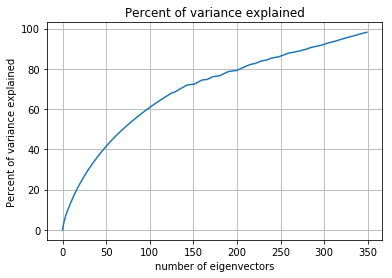

In [11]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:350]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [12]:
#i=5
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res= residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.975085646682
residual normalized norm  after mean + top eigs: [ 0.97015055  0.94767317  0.64915868  0.50632622  0.50621066  0.5050875
  0.49896048  0.49740634  0.49257062  0.48992757]


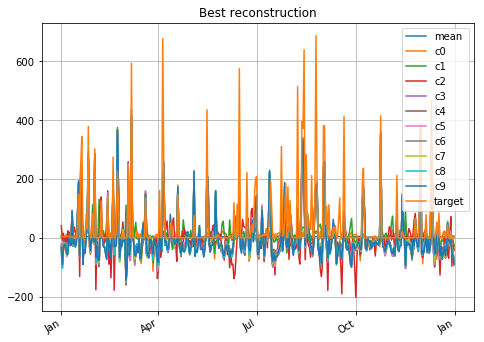

In [13]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [14]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(x=None,f=Series,mean=Mean,v=v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [15]:
rows=df.take(20)
#df.show(20)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3','res_4','res_5','res_6','res_7','res_8','res_9','res_10'):
        print field,':',row_out[field],
    print

res_mean : 0.976204689784 res_1 : 0.834799727366 res_2 : 0.814974030217 res_3 : 0.813351242675 res_4 : 0.796017975218 res_5 : 0.795921691914 res_6 : 0.794994675805 res_7 : 0.794730652623 res_8 : 0.79465952452 res_9 : 0.79369289301 res_10 : 0.793646622923
res_mean : 0.961858065589 res_1 : 0.982417145621 res_2 : 0.915848642548 res_3 : 0.603424154373 res_4 : 0.453822585571 res_5 : 0.451202830241 res_6 : 0.440129820277 res_7 : 0.438799321006 res_8 : 0.431349700422 res_9 : 0.428346273416 res_10 : 0.42251758152
res_mean : 0.972721687622 res_1 : 0.522651047813 res_2 : 0.50282527818 res_3 : 0.50138337084 res_4 : 0.498003974799 res_5 : 0.497780230063 res_6 : 0.496992298813 res_7 : 0.496269706599 res_8 : 0.481700503134 res_9 : 0.481525252569 res_10 : 0.480502861224
res_mean : 0.976327182945 res_1 : 0.97082237884 res_2 : 0.567047963713 res_3 : 0.48466658951 res_4 : 0.484661511594 res_5 : 0.48328417648 res_6 : 0.480566744952 res_7 : 0.470513781082 res_8 : 0.461504101254 res_9 : 0.448438519435 res_

In [16]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2784
after filter 2784


In [17]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [18]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%s, %4f'\
                    %(row['station'],row['year'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [19]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3','station','longitude','latitude').show(12)

+------------------+-------------------+-------------------+-------------------+-----------+---------+--------+
|          res_mean|              res_1|              res_2|              res_3|    station|longitude|latitude|
+------------------+-------------------+-------------------+-------------------+-----------+---------+--------+
|0.9748150615296891| 0.9580701025422554|0.46618180110126467|  0.360359993428343|US1ALBW0039| -87.9115| 30.4675|
|0.9729870661041783|  0.950965828435992|0.46917055542765135| 0.3681410843481568|US1ALBW0030|  -87.826| 30.5235|
|0.9735588196686185|0.42020049176222535|0.38354070995916795|0.38130859458170374|US1ALBW0039| -87.9115| 30.4675|
|0.9757043819387392|0.40391824287911926|0.38823984473736606|0.38788925878286107|US1ALMB0050| -88.0986| 30.6036|
|0.9710148122124509| 0.4174330829501147| 0.3948237637392064| 0.3946537352384832|US1ALMB0004|   -88.13|   30.69|
|0.9782469724050026| 0.4199685517517821|0.39626666109602454|0.39567342686255896|US1ALBW0003| -87.9076| 3

/root/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


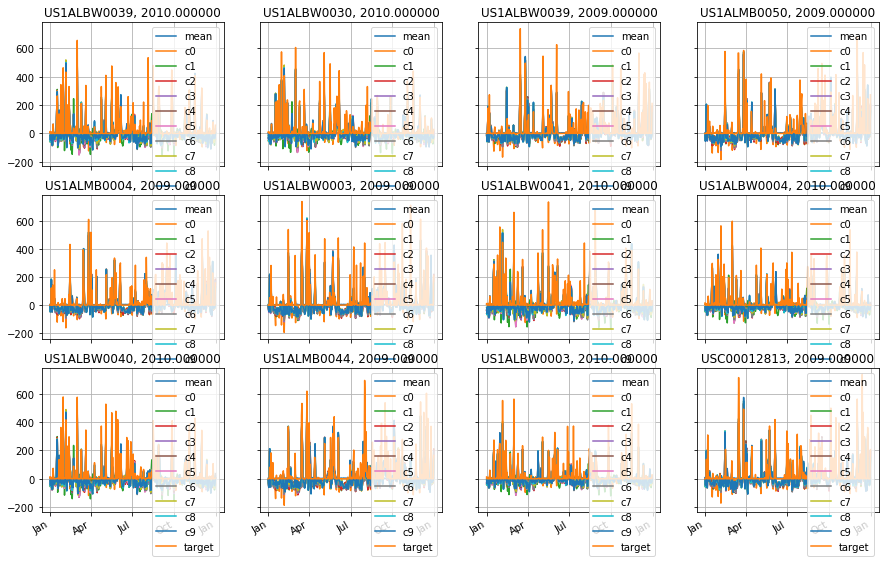

In [20]:
plot_recon_grid(rows)

In [21]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3','res_4','station','longitude','latitude').show(12)

+------------------+------------------+------------------+------------------+------------------+-----------+---------+--------+
|          res_mean|             res_1|             res_2|             res_3|             res_4|    station|longitude|latitude|
+------------------+------------------+------------------+------------------+------------------+-----------+---------+--------+
|0.9778107492371365|0.9999851410340223|0.9999841760158004|0.9999841713858975|0.9984321289364048|USC00013035| -88.0167| 30.2333|
|0.9762673597063696| 0.999936004147505|0.9999356044435624|0.9999353056437305|0.9960378008733535|USC00014193| -87.9278| 31.5253|
|0.9750851524098446|0.9999833506237392|0.9999456099548331| 0.999840313791637|0.9955133329265627|USC00016988| -87.7017| 30.5653|
|0.9735366784909426|0.9999975925810763|0.9999463085402777|0.9997989655314274|0.9967313516430129|USC00086240| -86.4928| 30.5317|
|0.9796025548902932|0.9999531994295725|0.9999281548271718| 0.999797348982753| 0.999190982381803|USW00013

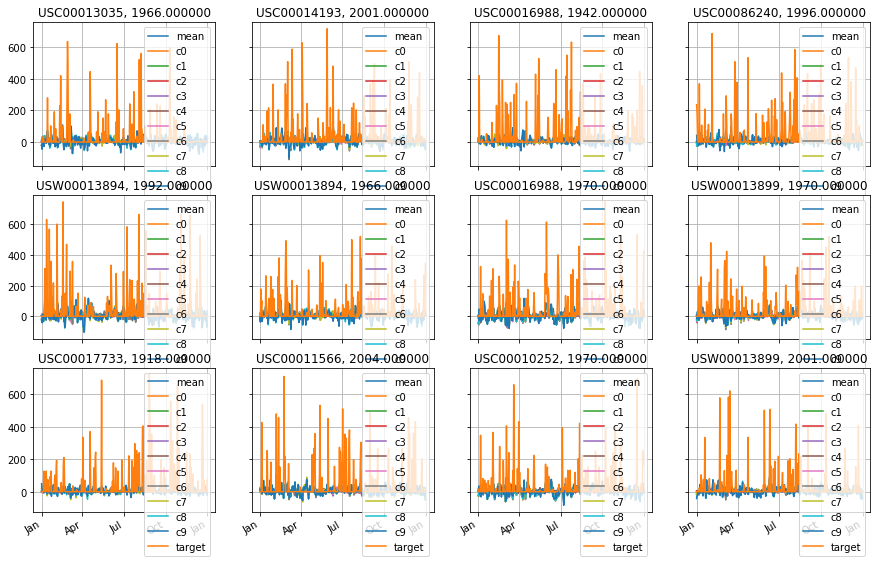

In [22]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

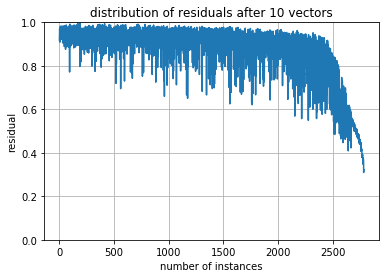

In [23]:
res3=df3.select('res_10').collect()
R10=[r['res_10'] for r in res3]
plot(R10)
title('distribution of residuals after 10 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [26]:

# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

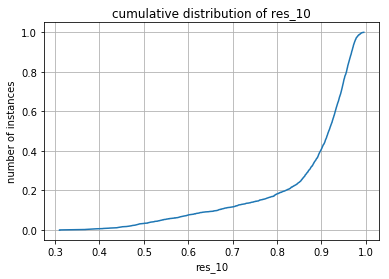

In [27]:
plot_CDF('res_10')

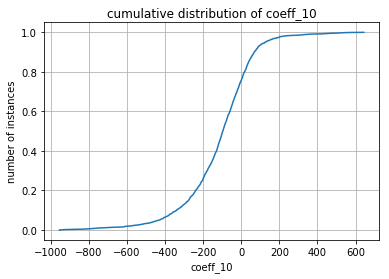

In [28]:
plot_CDF('coeff_10')

In [29]:
df4=df3.filter(df3.res_10<0.5).sort(df3.coeff_10)
rows=df4.take(12)
df4.select('coeff_10','res_10','station','latitude','longitude').show(12)

+-------------------+-------------------+-----------+--------+---------+
|           coeff_10|             res_10|    station|latitude|longitude|
+-------------------+-------------------+-----------+--------+---------+
| -405.0819487212425| 0.4947012020233574|US1ALBW0039| 30.4675| -87.9115|
| -360.3544617250079|0.48663731337857674|US1FLOK0016| 30.4586| -86.5815|
|-334.50276306279056| 0.4886744137026179|US1ALBW0030| 30.5235|  -87.826|
| -329.2054090588183|0.46426333266163916|US1ALBW0041|  30.517| -87.8455|
|-324.27150795571515|0.48509255109721233|US1FLOK0017| 30.4552| -86.6154|
|-211.89205473100776|  0.479734100359237|US1ALBW0005| 30.2902| -87.5099|
|-193.96007871329306|0.48480955263533043|USC00016988| 30.5653| -87.7017|
| -189.7034578733266| 0.4470830047925089|US1ALMB0044| 30.6811| -88.1195|
|-186.84020665067868| 0.4934861973477085|US1ALMB0049|  30.671|  -88.108|
|-177.15375713727028|  0.480897592488075|US1ALMB0032| 30.5117| -88.3218|
|-167.03721803923568|0.47739315220518946|USC0001698

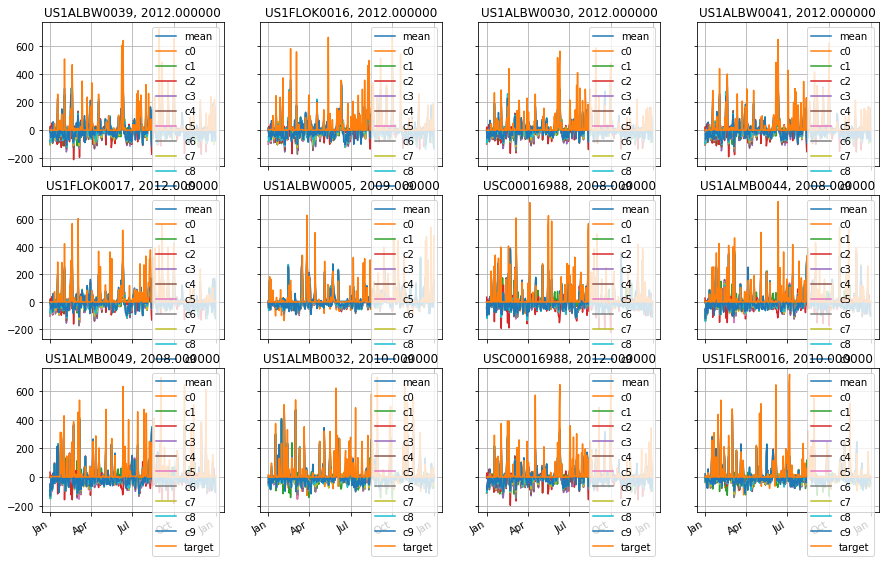

In [30]:
plot_recon_grid(rows)

In [33]:
df5=df3.filter(df3.res_10<0.5).sort(df3.coeff_10,ascending=False)
rows=df5.take(12)
df5.select('coeff_10','res_10','latitude','longitude').show(12)

+------------------+-------------------+--------+---------+
|          coeff_10|             res_10|latitude|longitude|
+------------------+-------------------+--------+---------+
|207.81610146623672| 0.4696178522050739|   31.21| -87.1789|
| 196.3308941516851|  0.434887529723946| 31.0583|  -87.055|
|142.00890457481523|0.40801080006899937| 30.6216| -87.7578|
| 114.4809359612185| 0.4879408510751086|  30.441| -87.8947|
| 67.90086254340036|0.48050286122433744| 30.5682| -88.2331|
| 67.17986919096379| 0.4737491431627379|  30.622| -87.9014|
|54.272897560320935| 0.4494942716685633| 31.1819| -87.4389|
|43.108623427471954| 0.3762301604107169| 30.6424| -87.9076|
|  39.0085608529244| 0.4624012943591839| 30.6808| -88.0888|
|34.065699389145934|0.36876094676286414| 30.6036| -88.0986|
| 27.32799009764379|0.47668280034301613| 30.4109| -86.6475|
| 27.30748741863286|0.49909151169614513| 30.5653| -87.7017|
+------------------+-------------------+--------+---------+
only showing top 12 rows



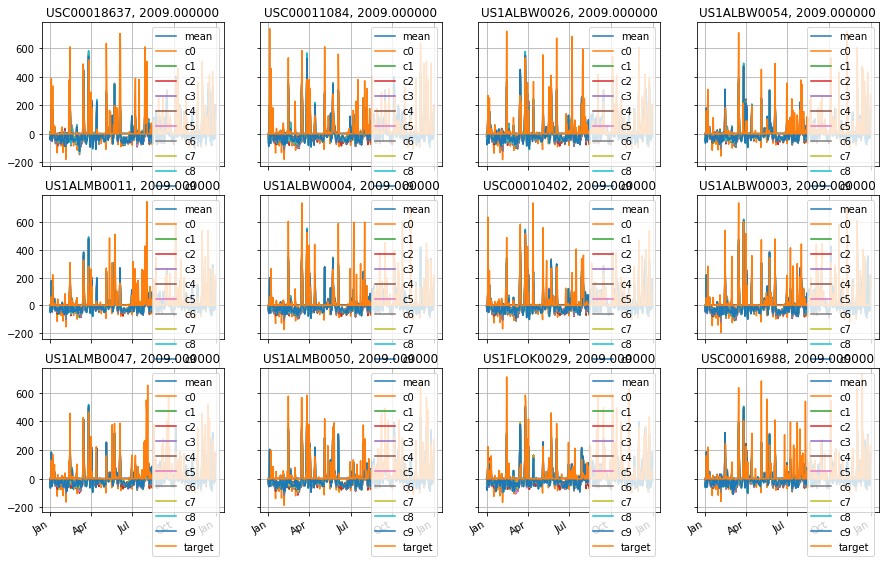

In [32]:
plot_recon_grid(rows)

In [33]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [34]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.5M	../../Data/Weather/US_Weather_BSSSBSBS.parquet
3.9M	../../Data/Weather/US_Weather_SSSSBBBB.parquet
1.7M	../../Data/Weather/decon_BBBSBBBB.parquet
1.7M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
2.5M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.8M	../../Data/Weather/decon_BSSSBSBS_PRCP.parquet
362K	../../Data/Weather/decon_BSSSBSBS_SNWD.parquet
